# TensorFlow 2.x

1. Create a mock dataset with a Gaussian noise
2. Set up a linear model f(x) = w x + b where w and b are the slope and intercept (bias) respectively.
3. Set up a cost function to be minimized in order to find the best values for w and b
4. Perform Gradient descent to minimize the cost.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [2]:
plt.rc('font', family='fantasy', size=20)

## Data

Create a set of mock data

In [3]:
tf.random.set_seed(12345)

w_true   = 3.0
b_true   = 2.0
num_data = 100
sigma    = 0.5

inputs  = tf.random.uniform(minval=0, maxval=1., shape=[num_data, 1])
noise   = tf.random.normal(mean=0.0, stddev=sigma, shape=[num_data, 1])
outputs = inputs * w_true + b_true + noise


# #
# #   Z-score standardization
# # 
# if scale:        
#     mean    = tf.math.reduce_mean(inputs)
#     std     = tf.math.reduce_std(inputs)
#     tmean   = tf.math.reduce_mean(outputs)
#     tstd    = tf.math.reduce_std(outputs)

#     inputs  = tf.divide(tf.subtract(inputs, mean), std)
#     outputs = tf.divide(tf.subtract(outputs, tmean), tstd)

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs)) 

In [4]:
class Model(object):
    def __init__(self):
        nfeatures = 1
        self.w_1 = tf.Variable(tf.random.truncated_normal([nfeatures, 1]), name='w_1')
        self.b_1 = tf.Variable(tf.random.truncated_normal([1, 1]), name='b_1')        
        #self.w_1 = tf.Variable(tf.zeros([nfeatures, 1]), name='w_1')
        #self.b_1 = tf.Variable(tf.ones([1, 1]), name='b_1')

    def __call__(self, a_0):
        a_1  = tf.add(tf.matmul(a_0, self.w_1), self.b_1)
        return a_1

def train(model, dataset, learning_rate, batch_size=5, data_size=100):
    #pbar = tqdm.tqdm(total=data_size)
    for x,y in dataset.batch(batch_size):            
        #
        #with tf.GradientTape() as t:
        #    current_loss = loss(model(x), y)
        #    dw1, db1 = t.gradient(current_loss, [model.w_1, model.b_1])
        #
        diff = tf.subtract(model(x), y) 
        db1  = tf.reduce_sum(diff, axis=0)[:, tf.newaxis]
        dw1  = tf.matmul(tf.transpose(x), diff)
        model.w_1.assign_sub(learning_rate * dw1)
        model.b_1.assign_sub(learning_rate * db1)
        #pbar.update(batch_size)
    #pbar.close()

def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

## Unscaled data

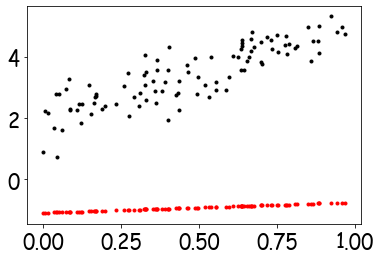

In [5]:
model = Model()
plt.scatter(inputs, outputs, marker='.', color='k')
plt.scatter(inputs, model(inputs), marker='.', color='r')

## Training

In [6]:
# Collect the history of W-values and b-values to plot later
model = Model()
w1 = []
b1 = []
num_epochs = 50

for epoch in range(num_epochs):    
    current_loss = loss(model(inputs), outputs)
    print('Epoch %2d :     w=%5.2f    b=%5.2f    loss=%8.5f'
         %(epoch, model.w_1.numpy(), model.b_1.numpy(), current_loss))
    w1 += [model.w_1.numpy()[0][0]]
    b1 += [model.b_1.numpy()[0][0]]
    
    train(model, dataset, learning_rate=0.01, batch_size=5)

Epoch  0 :     w= 0.43    b= 0.87    loss= 6.19891
Epoch  1 :     w= 1.23    b= 2.21    loss= 0.89048
Epoch  2 :     w= 1.51    b= 2.55    loss= 0.45363
Epoch  3 :     w= 1.66    b= 2.62    loss= 0.40267
Epoch  4 :     w= 1.75    b= 2.61    loss= 0.38376
Epoch  5 :     w= 1.84    b= 2.58    loss= 0.36897
Epoch  6 :     w= 1.91    b= 2.55    loss= 0.35598
Epoch  7 :     w= 1.98    b= 2.52    loss= 0.34445
Epoch  8 :     w= 2.04    b= 2.49    loss= 0.33422
Epoch  9 :     w= 2.10    b= 2.46    loss= 0.32514
Epoch 10 :     w= 2.16    b= 2.43    loss= 0.31709
Epoch 11 :     w= 2.21    b= 2.40    loss= 0.30994
Epoch 12 :     w= 2.26    b= 2.38    loss= 0.30361
Epoch 13 :     w= 2.31    b= 2.35    loss= 0.29798
Epoch 14 :     w= 2.36    b= 2.33    loss= 0.29299
Epoch 15 :     w= 2.40    b= 2.31    loss= 0.28856
Epoch 16 :     w= 2.44    b= 2.29    loss= 0.28464
Epoch 17 :     w= 2.48    b= 2.27    loss= 0.28115
Epoch 18 :     w= 2.51    b= 2.26    loss= 0.27806
Epoch 19 :     w= 2.55    b= 2.

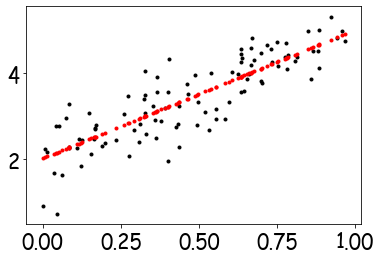

In [7]:
plt.scatter(inputs, outputs, marker='.', color='k')
plt.scatter(inputs, model(inputs), marker='.', color='r')

## Grid search 

In [8]:
model = Model()   # initiate the model

w_grid = tf.range(-2.,  5, 0.1)
b_grid = tf.range(-2., 5., 0.1)

loss_value = []
for w_i in w_grid:
    for b_i in b_grid:        
        model.w_1.assign([[w_i]])
        model.b_1.assign([[b_i]])        
        loss_value.append(loss(model(inputs), outputs))
        
Loss     = tf.Variable(loss_value)        
Loss_min = tf.reduce_min(Loss)        
dLoss    = tf.subtract(Loss, Loss_min)    # subtract the min
dLoss    = tf.reshape(Loss, (w_grid.shape[0], b_grid.shape[0])) # reshape

## Visualization

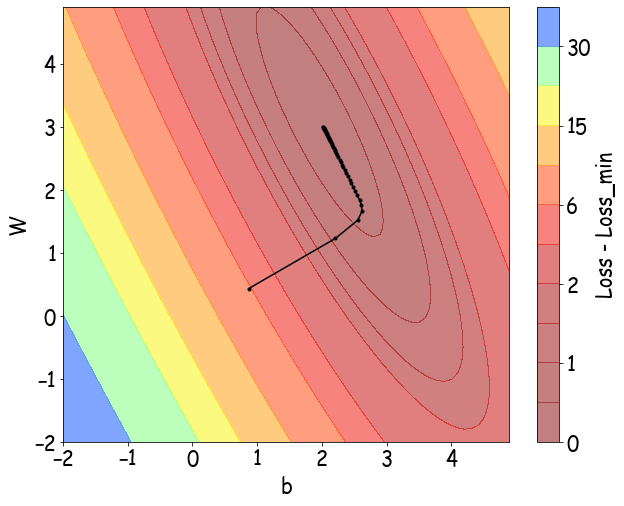

In [9]:
plt.figure(figsize=(10, 8))
plt.contourf(b_grid, 
             w_grid, 
             dLoss,
             alpha=0.5,
             cmap=plt.cm.jet_r,
             levels=[0, 0.5, 1., 1.5, 2., 4., 6., 10, 15, 20, 30, 50])

plt.plot(b1, w1, 'k', marker='.') #levels=[0, 1, 10, 30, 50, 100])

plt.xlabel('b')
plt.ylabel('W')
plt.colorbar(label='Loss - Loss_min')

In [29]:
# Backpropagation for two layers

# diff  = tf.subtract(a_2, y)
# d_z_2 = tf.multiply(diff, sigmaprime(z_2))
# d_b_2 = d_z_2
# d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)
# d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
# d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
# d_b_1 = d_z_1
# d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)
# eta = tf.constant(0.5)
# w_1= tf.subtract(w_1, tf.multiply(eta, d_w_1))
# b_1= tf.subtract(b_1, tf.multiply(eta,
#                            tf.reduce_mean(d_b_1, axis=[0])))
# w_2= tf.subtract(w_2, tf.multiply(eta, d_w_2))
# b_2= tf.subtract(b_2, tf.multiply(eta,
#                                   tf.reduce_mean(d_b_2, axis=[0])))